# Reading and editing well logs from ANP (.las format)

ANP well log data is provided in a worldwide standardized format named LAS, which is encoded as ASCII. However, there are some details that differ from, for example, the Canadian Well Logging Society, which developed the module LASReader used to read the files here. One of that differences is that the <b>DATE</b> parameter in the ANP files is referred as <b>SPUD</b>. Therefore, if you use the plot layout recommended for the module you need to edit the .las file from ANP in order to have this data printed in you image. Other example is that ANP logs for one well are generally offered in several different files, as the example shown bellow. So, some functions of the LASReader module, as <b>log.start</b> and <b>log.end</b> will not work properly since these commands will show the start and the end of the log segment stored in the file, instead of the start and end of the research.

The first think you need to do to read the lofs is to install the Python module LAS in your computer. Follow the link to download the file: https://pypi.python.org/pypi/las/0.0.3

The goal of this notebook is to edit the data to create a time-depth table. For this It is needed to:
    - read the raw data;
    - create parameters to store the data of each log, namely, DT, RHOB, GR, ILD, ...;
    - read the start/end depths and store them in parameters;
    - resize parameters the the total size of the depth - otherwise it's not possible to plot them together;
    - convert log null values (generally -999.250) to array null values (nan);
    - assign geological markers and its depths;
    - find indices for the depth and segment layers according to the markers depth;
    - calculate the thickness of the layers;
    - define the thickness of the sub-layers for building a detailed model based on the markers;
    - calculate the thickness of the sub-layers created;
    - find the indices of the new sub-markers;
    - calculate the average velocity and density inside of the defined intervals;
    - create an array assigned with depth indices to plot the interval velocity and density curves;
    - calculate the acoustic impedance for each interval;
    - calculate the reflexion coefficients for each interface;
    - create a ricker pulse to be used with the convolution of the reflexion coefficients;
    - create a new array indexed with the depth to store the reflexion coefficients;
    - create the synthetic seismogram convolving the reflexion coefficients with the ricker pulse;
    - plot the results;
    - calculate and export the time-depth table.

In this notebook only the logs DT and RHOB will be read and edited. If you are interested in working with other logs, please, follow the link: https://github.com/petroGG/Basic-Well-Log-Interpretation

## Importing the LAS module and other tools:

In [1]:
import las

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import math

from IPython.display import Image

from IPython.display import display, Latex

In [2]:
# The automatic function is still not working. Feel free to fix this part of the code.

In [3]:
# log_files = ('perfis/1RJS_0051__RJ_1RJS_0051__RJ_BHC_00003.las', 'perfis/1RJS_0051__RJ_1RJS_0051__RJ_FDC_CNL_00001.las', 'perfis/1RJS_0051__RJ_1RJS_0051__RJ_FDC_CNL_GR_00004.las', 'perfis/1RJS_0051__RJ_1RJS_0051__RJ_IES_00005.las', 'perfis/1RJS_0051__RJ_1RJS_0051__RJ_ISF_BHC_GR_00002.las')

In [4]:
# N_logs = len(log_files)
# N_logs

In [5]:
# for i in range(N_logs):
#     for filename in log_files[i]:
#         globals()['log%s' % i] = las.LASReader(filename)

In [6]:
# Define the number of files the well has:

In [7]:
# N_perfis = 5

## Reading the files:

In [8]:
log1 = las.LASReader('perfis/1RJS_0051__RJ_1RJS_0051__RJ_BHC_00003.las')
log1.data     # this command exhibit the data stored in this file

array([( 2290.7732,  87.6466), ( 2290.9256,  88.5077),
       ( 2291.078 ,  89.8586), ..., ( 3532.5284,  88.619 ),
       ( 3532.6808,  87.8055), ( 3532.8332,  85.4789)],
      dtype=[('DEPT', '<f8'), ('DT', '<f8')])

In [9]:
log2 = las.LASReader('perfis/1RJS_0051__RJ_1RJS_0051__RJ_FDC_CNL_00001.las')
log2.data

array([(  574.292 ,  1.8759), (  574.4444,  1.8448), (  574.5968,  1.8203),
       ..., ( 2301.5936,  2.2733), ( 2301.746 ,  2.2606),
       ( 2301.8984,  2.2719)],
      dtype=[('DEPT', '<f8'), ('RHOB', '<f8')])

In [10]:
log3 = las.LASReader('perfis/1RJS_0051__RJ_1RJS_0051__RJ_FDC_CNL_GR_00004.las')
log3.data

array([( 2295.3452,   76.8985, -999.25  ),
       ( 2295.4976,   76.2669, -999.25  ),
       ( 2295.65  ,   77.0666, -999.25  ), ...,
       ( 3536.6432, -999.25  ,    2.6824),
       ( 3536.7956, -999.25  ,    2.6799),
       ( 3536.948 , -999.25  ,    2.6827)],
      dtype=[('DEPT', '<f8'), ('GR', '<f8'), ('RHOB', '<f8')])

In [11]:
log4 = las.LASReader('perfis/1RJS_0051__RJ_1RJS_0051__RJ_IES_00005.las')
log4.data

array([( 2302.2032,   0.567 ), ( 2302.3556,   0.5582),
       ( 2302.508 ,   0.5472), ..., ( 3533.5952,  15.4005),
       ( 3533.7476,  14.7789), ( 3533.9   ,  14.1661)],
      dtype=[('DEPT', '<f8'), ('ILD', '<f8')])

In [12]:
log5 = las.LASReader('perfis/1RJS_0051__RJ_1RJS_0051__RJ_ISF_BHC_GR_00002.las')
log5.data

array([(  574.292 ,  101.4119,  0.9593), (  574.4444,  105.9016,  1.0592),
       (  574.5968,  109.1162,  1.1506), ...,
       ( 2301.5936, -999.25  ,  0.5651), ( 2301.746 , -999.25  ,  0.5677),
       ( 2301.8984, -999.25  ,  0.5696)],
      dtype=[('DEPT', '<f8'), ('DT', '<f8'), ('ILD', '<f8')])

In [13]:
np.set_printoptions(precision=4)

## Creating parameters to store the data:

In [14]:
DT = np.append(log5.data['DT'], log1.data['DT'])
RHOB = np.append(log2.data['RHOB'], log3.data['RHOB'])
DEPT = np.append(log5.data['DEPT'], log1.data['DEPT'])

## Reading the start and end of the depth:

In [15]:
DEPT_start = DEPT[0]
DEPT_end = DEPT[-1]

In [16]:
print DEPT_start

574.292


In [17]:
print DEPT_end

3532.8332


## Resizing parameters the the total size of the depth:

In [18]:
# Check the size of each parameter:

In [19]:
DT.size

19488

In [20]:
RHOB.size

19485

In [21]:
DEPT.size

19488

In [22]:
# P.S.: Check in your raw data if the logs start before or end after the other in order to resize at the right place.

In [23]:
if RHOB.size < DEPT.size:
    RHOB.resize(DEPT.size,)
print RHOB

if DT.size < DEPT.size:
    DT.resize(DEPT.size,)
print DT

[ 1.8759  1.8448  1.8203 ...,  0.      0.      0.    ]
[ 101.4119  105.9016  109.1162 ...,   88.619    87.8055   85.4789]


## Assigning null values in an array as 'nan':

In [24]:
# Replace null values (-999.25) by 'nan':

In [25]:
log1.null      # function from the LASReader that shows the value assigned as null in the log files.

-999.25

In [26]:
# finding the indices of null values

In [27]:
np.where(DT == -999.25)

(array([11261, 11262, 11263, 11264, 11265, 11266, 11267, 11268, 11269,
        11270, 11271, 11272, 11273, 11274, 11275, 11276, 11277, 11278,
        11279, 11280, 11281, 11282, 11283, 11284, 11285, 11286, 11287,
        11288, 11289, 11290, 11291, 11292, 11293, 11294, 11295, 11296,
        11297, 11298, 11299, 11300, 11301, 11302, 11303, 11304, 11305,
        11306, 11307, 11308, 11309, 11310, 11311, 11312, 11313, 11314,
        11315, 11316, 11317, 11318, 11319, 11320, 11321, 11322, 11323,
        11324, 11325, 11326, 11327, 11328, 11329, 11330, 11331, 11332,
        11333, 11334, 11335, 11336]),)

In [28]:
np.where(RHOB == -999.25)

(array([11337, 11338, 11339, 11340, 11341, 11342, 11343, 11344, 11345,
        11346, 11347, 11348, 11349, 11350, 11351, 11352, 11353, 11354,
        11355, 11356, 11357, 11358, 11359, 11360, 11361, 11362, 11363,
        11364, 11365, 11366, 11367, 11368, 11369, 11370, 11371, 11372,
        11373, 11374, 11375, 11376, 11377, 11378, 11379, 11380, 11381]),)

In [29]:
 # Replacing null values (-999.25 and 0.0000) by 'nan':

In [30]:
for i in range(DT.size):
    if DT[i] <= 0:
        DT[i] = np.put(DT, [i], np.nan)

In [31]:
for i in range(RHOB.size):
    if RHOB[i] <= 0:
        RHOB[i] = np.put(RHOB, [i], np.nan)

## Assigning geological markers and its depths:

In [32]:
# I aasigned the first formation logged with the start depth. Otherwise, the name of the formation is not displayed at
# the graphic.

In [33]:
markers = ('Fm. Embore', 'Fm. Ubatuba', 'Mb. Goitacas', 'Mb. Retiro', 'Mb. Itabapoana', 'Mb. Coqueiros')

In [34]:
depths_markers = (574.292, 1983, 2002, 2396, 2420, 3344)

## Finding indices for the markers depth:

In [35]:
# Create a new parameter for storing the base of the markers:

In [36]:
depths_bottom = np.append(depths_markers[1:], DEPT_end)
depths_bottom

array([ 1983.    ,  2002.    ,  2396.    ,  2420.    ,  3344.    ,
        3532.8332])

## Segmenting the depths according to the markers depths:

In [37]:
N_markers = len(markers)

for i in range(N_markers):
    idx_top = (np.abs(DEPT - depths_markers[i])).argmin()
    idx_bottom = (np.abs(DEPT - depths_bottom[i])).argmin()
    
    globals()['layer%s' % i] = DEPT[idx_top:idx_bottom]


In [38]:
layer0

array([  574.292 ,   574.4444,   574.5968, ...,  1982.468 ,  1982.6204,
        1982.7728])

##  Calculating the thickness of the layers:

In [39]:
thickness_layers=[]

for i in range(N_markers):
    thickness_l = globals()['layer%s' % i][-1] - globals()['layer%s' % i][0]
    thickness_layers = np.append(thickness_layers, thickness_l)
print thickness_layers

[ 1408.4808    18.8976   393.8016    23.9268   923.8488   188.6712]


## Defining the thickness of the sub-layers for building a model based on the markers:

In [40]:
# Choose below the thickness of the sub-layers you would like to model above and below of each marker:

# Use zero(0) for no sub-layers

In [41]:
sub_layer_thickness = 10.

In [42]:
# Finding the depths of the upper sub-layers and the lower sub-layers:

In [43]:
sub_markers_top = []

for i in range(1, N_markers):
    sub_markers_t = depths_markers[i] - sub_layer_thickness
    sub_markers_top = np.append(sub_markers_top, sub_markers_t)

print sub_markers_top

[ 1973.  1992.  2386.  2410.  3334.]


In [44]:
sub_markers_bottom = []
    
for i in range(1, N_markers):
    
    sub_markers_b = depths_markers[i] + sub_layer_thickness
    sub_markers_bottom = np.append(sub_markers_bottom, sub_markers_b)
    
print sub_markers_bottom

[ 1993.  2012.  2406.  2430.  3354.]


In [45]:
# Finding the depths of tops and bottoms of sub-layers:

In [46]:
total_layers = np.append(depths_markers, sub_markers_top)
total_layers = np.append(total_layers, sub_markers_bottom)
total_layers = np.append(total_layers, DEPT_end)
total_layers = np.unique(np.sort(total_layers))
total_layers

array([  574.292 ,  1973.    ,  1983.    ,  1992.    ,  1993.    ,
        2002.    ,  2012.    ,  2386.    ,  2396.    ,  2406.    ,
        2410.    ,  2420.    ,  2430.    ,  3334.    ,  3344.    ,
        3354.    ,  3532.8332])

## Calculating the thickness of the sub-layers created:

In [47]:
thickness_total_layers=[]

N = total_layers.size

for i in range(N-1):
    thickness_t = total_layers[i+1] - total_layers[i]
    thickness_total_layers = np.append(thickness_total_layers, thickness_t)

np.set_printoptions(formatter={'float_kind':'{:f}'.format})    
print thickness_total_layers

[1398.708000 10.000000 9.000000 1.000000 9.000000 10.000000 374.000000
 10.000000 10.000000 4.000000 10.000000 10.000000 904.000000 10.000000
 10.000000 178.833200]


In [48]:
thickness_total_layers.size

16

## Finding the indices of the new sub-markers:

In [49]:
idx=[]

for i in range(total_layers.size):
    id = (np.abs(DEPT - total_layers[i])).argmin()
    idx = (np.append(idx, id))

idx = idx.astype(int)
    
print idx

[    0  9178  9243  9303  9309  9368  9434 11962 12027 12093 12119 12185
 12251 18182 18248 18314 19487]


## Calculating the average velocity and density inside of the defined intervals:

In seismic processing, the interval velocity is defined based on pairs of reflectors, according to Yilmaz (2001):

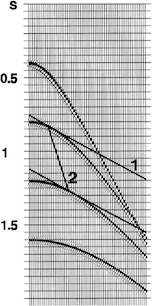

In [50]:
from IPython.display import Image
Image("imagens/interval_vel.png")

Inside of that intervals, defined by reflectors, the average velocity is calculated by the following expression (Yilmaz, 2001): 

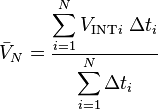

In [51]:
from IPython.display import Image
Image("imagens/average_vel.png")

Here, I am considering each geological marker as a reflector, because both by definition represent the same event: an interface that presents some change in petrophysical properties. To calculate the average velocity here I used as V_int the values shown in the logs associated with the depth of the marker or sub-marker. For simplification, I am not considering the influence of the time or depth but I checked that the error associated with this simplification is smaller than 0.0001%. If I would use the depth instead of the time, I would have to change the units of the logs from microsseconds per foot (DT) to meters and from grams per cubic centimeter (RHOB) to meters. I've noticed that the error is greater with the depth. So, I've used in the calculus below the las two samples of the DT log. Check below the calculus:

In [52]:
DT_m = DT/0.3048     # 1 foot = 0.3048 m

In [53]:
DEPT.size

19488

In [54]:
DT_m[19487]    # remember that python starts to count on zero and not on one. Because of it the index is one less.

280.44258530183725

In [55]:
DT_m[-1]      # or you can count from backwards.

280.44258530183725

In [56]:
DT_m[-2]

288.07578740157476

In [57]:
# Calculating the average velocity with the modificated Yilmaz (2001) formula:

In [58]:
V_n = (DT_m[-1]*DEPT[-1] + DT_m[-2]*DEPT[-2])/(DEPT[-1]+DEPT[-2])
V_n

284.25910402931589

In [59]:
# now I will calculate the average velocity consideting only the DT log:

In [60]:
V_m = np.mean(DT_m[-2:])
V_m

284.25918635170603

In [61]:
np.isclose(V_n, V_m, 0.000001)

True

So, as you can see above, when you use the formula of Yilmaz (2001) you are calculating the weighted average, while if you use the numpy function "np.mean" you are calculating the simple average. I've opted to use the simple average for simplification.

In [ ]:
# Calculating the average velocity for the layers model created above:

In [62]:
average_vel=[]
for i in range(idx.size - 1):
    v_m = np.nanmean(DT[idx[i]:idx[i+1]])
    average_vel = np.append(average_vel, v_m)
               
print average_vel

[112.434293 93.574931 97.867392 103.109167 102.021493 108.165403 81.571885
 112.881962 58.971898 54.765923 55.831071 78.406152 75.988221 76.592382
 67.948333 63.926102]


In [63]:
# Calculating the average density (RHOB) for the layers model created above:

In [64]:
average_density=[]

for i in range(idx.size-1):
    RHOB_m = np.nanmean(RHOB[idx[i]:idx[i+1]])
    average_density = np.append(average_density, RHOB_m)
               
print average_density

[2.219699 2.249702 2.345428 2.350250 2.327825 2.269264 2.298975 2.370197
 2.930933 2.940331 2.740453 2.507495 2.454687 2.607344 2.541042 2.614830]


## Creating an array assigned with depth to plot the interval velocity and density curves:

In [65]:
# Creating an array indexed to the depth for the interval velocity:

In [66]:
DT_int=np.zeros(DT.size)

for i in range(average_vel.size):
    DT_int[idx[i]:idx[i+1]] = average_vel[i]
    
DT_int = np.where(DT_int == 0, np.nan, DT_int)

print DT_int

[112.434293 112.434293 112.434293 ..., 63.926102 63.926102 nan]


In [67]:
RHOB_int=np.zeros(RHOB.size)

for i in range(average_density.size):
    RHOB_int[idx[i]:idx[i+1]] = average_density[i]
    
RHOB_int = np.where(RHOB_int == 0, np.nan, RHOB_int)

print RHOB_int

[2.219699 2.219699 2.219699 ..., 2.614830 2.614830 nan]


## Calculating the acoustic impedance for each interval:

<center> $ I = V_{int} \rho \hspace{15cm} $</center>

Where: $I$ = Acoustic Impedance, $V_{int}$ = Interval Velocity and $\rho$ = Interval porosity

In [68]:
IMP=[]

for i in range(average_density.size):
    I = average_vel[i]*average_density[i]
    IMP = np.append(IMP, I)
print IMP

[249.570249 210.515666 229.540953 242.332319 237.488226 245.455816
 187.531754 267.552478 172.842703 161.029929 153.002428 196.603069
 186.527284 199.702683 172.659598 167.155887]


## Calculating the reflexion coefficients for each interface:

The reflexion coefficients are adimensionals. Because of this it's not necessary to be worried about units. The coefficients can be found by the following formula:

<center> $ R_{coef} = \dfrac{I_{2} - I_{1}}{I_{2} + I_{1}} \hspace{15cm} $</center>

Where: $I$ = Acoustic Impedance

In [70]:
coef_ref = []

for i in range(IMP.size-1):
    coef = (IMP[i+1]-IMP[i])/(IMP[i+1]+IMP[i])
    coef_ref = np.append(coef_ref, coef)

print coef_ref

[-0.084885 0.043234 0.027108 -0.010096 0.016498 -0.133778 0.175837
 -0.215056 -0.035381 -0.025563 0.124714 -0.026299 0.034113 -0.072626
 -0.016196]


In [71]:
# Assign the reflexion coefficients to the depth indices:

In [72]:
depth_coef = DEPT[idx[1:-1]]      # remove the first and last values associated with the start and end of the logs.
depth_coef

array([1973.019200, 1982.925200, 1992.069200, 1992.983600, 2001.975200,
       2012.033600, 2386.023200, 2395.929200, 2405.987600, 2409.950000,
       2420.008400, 2430.066800, 3333.951200, 3344.009600, 3354.068000])

## Creating a ricker pulse to be used with the convolution of the reflexion coefficients:

In [73]:
def ricker(f, length=0.512, dt=0.004):
    t = np.arange(-length/2, length/2, dt)
    y = (1.-2.*(np.pi**2)*(f**2)*(t**2))*np.exp(-(np.pi**2)*(f**2)*(t**2))
    
    return t, y

In [74]:
f = 5
t, wavelet = ricker (f)

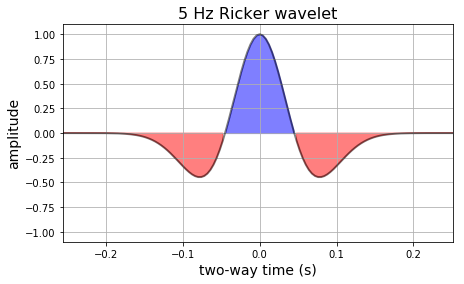

In [75]:
plt.figure(figsize=(7,4))
plt.plot( t, wavelet, lw=2, color='black', alpha=0.5)
plt.fill_between(t, wavelet, 0,  wavelet > 0.0, interpolate=False, color='blue', alpha = 0.5)
plt.fill_between(t, wavelet, 0, wavelet < 0.0, interpolate=False, color='red', alpha = 0.5)

# Axes configuration and settings (optional)
plt.title('%d Hz Ricker wavelet' %f, fontsize = 16 )
plt.xlabel( 'two-way time (s)', fontsize = 14)
plt.ylabel('amplitude', fontsize = 14)
plt.ylim((-1.1,1.1))
plt.xlim((min(t),max(t)))
plt.grid()
plt.show()

## Creating a new array indexed with the depth to store the reflexion coefficients:

In [76]:
idx_markers = idx[1:-1]
idx_markers

array([ 9178,  9243,  9303,  9309,  9368,  9434, 11962, 12027, 12093,
       12119, 12185, 12251, 18182, 18248, 18314])

In [ ]:
# checking the indices which have values different from zero

In [77]:
sint_sismo = np.zeros(DEPT.size)
np.put(sint_sismo, [idx_markers], [coef_ref])
np.where(sint_sismo != 0)

(array([ 9178,  9243,  9303,  9309,  9368,  9434, 11962, 12027, 12093,
        12119, 12185, 12251, 18182, 18248, 18314]),)

## Creating the synthetic seismogram:

The synthetic seismogram is the result of the convolution between the reflexion coefficients and the wavelet created above.

In [78]:
seismogram = np.convolve(sint_sismo, wavelet, mode='same')
seismogram.size

19488

## Plotting the results:

In [79]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)


# Create the figure and subplots
def combo_plot(top_depth,bottom_depth):
    
    fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(16,10), sharey=True)
    fig.suptitle("Well Composite", fontsize=22)
    fig.subplots_adjust(top=0.8,wspace=0.1)
    
#General setting for all axis
    for axes in ax:
        axes.set_ylim (top_depth,bottom_depth)
        axes.invert_yaxis()
        axes.yaxis.grid(True)
        axes.get_xaxis().set_visible(False) 
        for (i,j) in zip(depths_markers,markers):
            if ((i>=top_depth) and (i<=bottom_depth)):
                axes.axhline(y=i, linewidth=0.5, color='black')
                axes.text(0.2, i ,j, horizontalalignment='left',verticalalignment='top')
    
#1st track: DT
    
    ax01=ax[0].twiny()
    ax01.set_xlim(240.0,40.0)
    ax01.spines['top'].set_position(('outward',0))
    ax01.set_xlabel("DT [Us/foot]")
    ax01.plot(DT, DEPT, label='DT[Us/foot]', color='black')
    ax01.set_xlabel('DT[Us/foot]',color='black')    
    ax01.tick_params(axis='x', colors='black')
    ax01.grid(True)
    
    ax02=ax[0].twiny()
    ax02.set_xlim(240.0,40.0)
    ax02.spines['top'].set_position(('outward',40))
    ax02.set_xlabel("DT [Us/foot]")
    ax02.plot(DT_int, DEPT, label='DT[Us/foot]', color='green')
    ax02.set_xlabel('Interval Velocity',color='green')    
    ax02.tick_params(axis='x', colors='green')
    ax02.grid(True)
    
#2nd track: RHOB

    ax11=ax[1].twiny()
    ax11.set_xlim(0,3.0)
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',0))
    ax11.set_xlabel('RHOB[g/cc]', color='red')
    ax11.plot(RHOB, DEPT, label='RHOB[g/cc]', color='red')
    ax11.tick_params(axis='x', colors='red') 
    
    ax11=ax[1].twiny()
    ax11.set_xlim(0,3.0)
    ax11.grid(True)
    ax11.spines['top'].set_position(('outward',40))
    ax11.set_xlabel('Interval Density', color='black')
    ax11.plot(RHOB_int, DEPT, label='RHOB[g/cc]', color='black')
    ax11.tick_params(axis='x', colors='black')
    
    
#3nd track: COEF
    
    ax21=ax[2].twiny()
    ax21.set_xlim(-0.3,0.3)
    ax21.spines['top'].set_position(('outward',0))
    ax21.set_xlabel("Reflexion Coefficients")
    
    x = coef_ref
    y = depth_coef
    
    ax21.hlines(y, 0, x, color='red')
    ax21.plot(x, y, 'D')  # Stem ends
    ax21.grid(True)   
    
#4nd track: Synthetic Seismogram
    
    ax31=ax[3].twiny()
    ax31.set_xlim(-0.3,0.3)
    ax31.spines['top'].set_position(('outward',0))
    ax31.set_xlabel("Synthetic Seismogram")
    ax31.plot(seismogram, DEPT, lw=1, color='black', alpha=0.1)  
    ax31.fill_between(seismogram, DEPT, 0, seismogram > 0., interpolate=False, color='blue', alpha = 0.5)
    ax31.fill_between(seismogram, DEPT, 0, seismogram < 0., interpolate=False, color='red', alpha = 0.5)
    
    ax31.grid(True)   
    
#5nd track: Layers
    
    ax41=ax[4].twiny()
    ax41.set_xlim([ -150, 150])
    ax41.grid(True)
    ax41.set_xlabel('Model with 16 layers', color='black')
    cmap = get_cmap(N-1)
    for i in range(N-1):
        rect = plt.Rectangle((-150, total_layers[i]), 300, thickness_total_layers[i], alpha = 0.5, facecolor=cmap(i))
        ax41.add_artist(rect)
        
    ax41.set_xticks([])
    

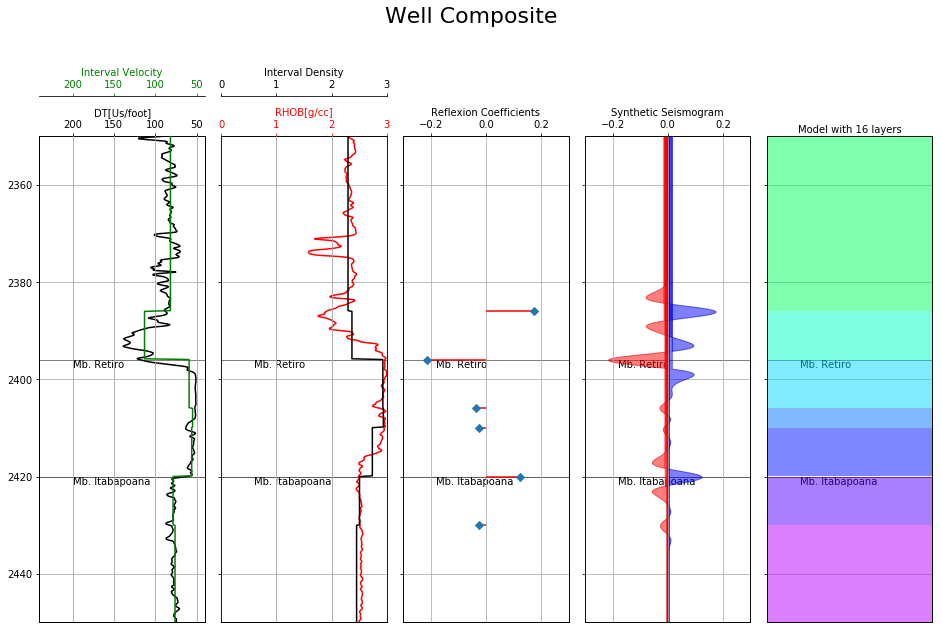

In [80]:
top_depth= 2350
bottom_depth=2450

combo_plot(top_depth,bottom_depth)

## Calculating and exporting the time-depth table:

For this calculus I will use the velocity log to find the time in milliseconds of each geological marker. Bringing the values:

In [81]:
print markers

('Fm. Embore', 'Fm. Ubatuba', 'Mb. Goitacas', 'Mb. Retiro', 'Mb. Itabapoana', 'Mb. Coqueiros')


In [82]:
print depths_markers

(574.292, 1983, 2002, 2396, 2420, 3344)


But the detailed model if used can help to reduce the error:

In [83]:
print total_layers

[574.292000 1973.000000 1983.000000 1992.000000 1993.000000 2002.000000
 2012.000000 2386.000000 2396.000000 2406.000000 2410.000000 2420.000000
 2430.000000 3334.000000 3344.000000 3354.000000 3532.833200]


In [84]:
print thickness_total_layers    # These depth values are already in meters

[1398.708000 10.000000 9.000000 1.000000 9.000000 10.000000 374.000000
 10.000000 10.000000 4.000000 10.000000 10.000000 904.000000 10.000000
 10.000000 178.833200]


Now it is necessary to ignore the marker located at the index [0] because it was included only for decoration purpose. To find the time related to each marker I need first to extrapolate the value of the velocity, since the start of the logs until the sea bottom and then from the sea bottom until the surface. So, I will use the average velocity of the first layer and the velocity of the p wave in the water for extrapolate that two regions.

In [85]:
SB = -(log1.well.EGL.value)      # ground level - sea bottom depth
SB

43.0

The depths listed at the .las file are assigned to the depth of the drill floor!!

In [86]:
DF = log1.well.EDF.value      # elevation of the drill floor
DF

22.0

It means that the depth of the markers, in relation to the sea bottom are 22 meters above the log's depth.

In [87]:
t_layers = total_layers

np.put(t_layers, [0], [0])
tot_layers = np.insert(t_layers, 1, SB)
tot_layers

array([0.000000, 43.000000, 1973.000000, 1983.000000, 1992.000000,
       1993.000000, 2002.000000, 2012.000000, 2386.000000, 2396.000000,
       2406.000000, 2410.000000, 2420.000000, 2430.000000, 3334.000000,
       3344.000000, 3354.000000, 3532.833200])

In [88]:
tot_layers_2 = tot_layers[2:]-22
tot_layers_2

array([1951.000000, 1961.000000, 1970.000000, 1971.000000, 1980.000000,
       1990.000000, 2364.000000, 2374.000000, 2384.000000, 2388.000000,
       2398.000000, 2408.000000, 3312.000000, 3322.000000, 3332.000000,
       3510.833200])

In [89]:
tot_layers_22 = np.insert(tot_layers_2, [0], [0, SB])     # now the depths are corrected
tot_layers_22

array([0.000000, 43.000000, 1951.000000, 1961.000000, 1970.000000,
       1971.000000, 1980.000000, 1990.000000, 2364.000000, 2374.000000,
       2384.000000, 2388.000000, 2398.000000, 2408.000000, 3312.000000,
       3322.000000, 3332.000000, 3510.833200])

In [ ]:
# Recalculating the thickness:

In [90]:
thickness_total_layers_2=[]

N = tot_layers_22.size

for i in range(N-1):
    thickness_t2 = tot_layers_22[i+1] - tot_layers_22[i]
    thickness_total_layers_2 = np.append(thickness_total_layers_2, thickness_t2)
    
print thickness_total_layers_2

[43.000000 1908.000000 10.000000 9.000000 1.000000 9.000000 10.000000
 374.000000 10.000000 10.000000 4.000000 10.000000 10.000000 904.000000
 10.000000 10.000000 178.833200]


In [91]:
np.sum(thickness_total_layers_2)    # checking the result

3510.8332

The sonic travel time is known as <b>slowness</b>. Because of this we see that the log curve has a tendency to have lower velocities with the increase of the depth. But the velocity used for the time-depth convertion is known as <b>RMS (root-mean-square) velocity </b> and it is the inverse of the sonic travel time. The unit generally shown is m/s.

In [92]:
average_vel

array([112.434293, 93.574931, 97.867392, 103.109167, 102.021493,
       108.165403, 81.571885, 112.881962, 58.971898, 54.765923, 55.831071,
       78.406152, 75.988221, 76.592382, 67.948333, 63.926102])

In [93]:
# Converting the DT log from microsseconds to millisseconds and from foot to meter:

In [94]:
vel_Usm = average_vel/0.3048    # converting from foot to meter
vel_Usm

array([368.878914, 307.004366, 321.087243, 338.284668, 334.716185,
       354.873370, 267.624296, 370.347643, 193.477357, 179.678225,
       183.172806, 257.238030, 249.305187, 251.287342, 222.927603,
       209.731305])

In [95]:
Vp = 1e6 / vel_Usm        # Converting from microsseconds to seconds and inverting the log
Vp                     

array([2710.916681, 3257.282666, 3114.418345, 2956.090228, 2987.605752,
       2817.906571, 3736.581524, 2700.165694, 5168.563466, 5565.504658,
       5459.325665, 3887.450080, 4011.147992, 3979.508050, 4485.761240,
       4768.005436])

In [ ]:
# It's necessary to add the velocity of the P wave for the salty water before the first index:

In [96]:
Vp_water = 1500   # m/s

In [97]:
Vp = np.insert(Vp, 0, Vp_water)
Vp         # in meters per second

array([1500.000000, 2710.916681, 3257.282666, 3114.418345, 2956.090228,
       2987.605752, 2817.906571, 3736.581524, 2700.165694, 5168.563466,
       5565.504658, 5459.325665, 3887.450080, 4011.147992, 3979.508050,
       4485.761240, 4768.005436])

In [ ]:
# calculating the time to cross each layer:

In seismic sections the time displayed is related to the two way travel time. Because of it we need to multiply the thickness per 2.

<center> $ TWT = \dfrac{2t}{V_{RMS}}   \hspace{15cm} $ </center>

Where: $t$ = thickness of the layers and $V_{RMS}$ = RMS velocity

In [99]:
ti=0
time = []

for i in range(Vp.size):
    t = thickness_total_layers_2[i]*2/ Vp[i]
    ti = (t + ti)
    time = np.append(time, ti)

time = time * 1000       # in milliseconds
    
print time      

[57.333333 1464.975267 1471.115355 1476.894925 1477.571495 1483.596386
 1490.693853 1690.876827 1698.283780 1702.153327 1703.590752 1707.254209
 1712.398969 2163.142747 2168.168494 2172.627046 2247.640887]


In [100]:
Time = np.array([time])
Time.T

array([[57.333333],
       [1464.975267],
       [1471.115355],
       [1476.894925],
       [1477.571495],
       [1483.596386],
       [1490.693853],
       [1690.876827],
       [1698.283780],
       [1702.153327],
       [1703.590752],
       [1707.254209],
       [1712.398969],
       [2163.142747],
       [2168.168494],
       [2172.627046],
       [2247.640887]])

In [101]:
# Depths:

In [102]:
depth = tot_layers_22[1:]*-1
depth

Depth = np.array([depth])
Depth.T

array([[-43.000000],
       [-1951.000000],
       [-1961.000000],
       [-1970.000000],
       [-1971.000000],
       [-1980.000000],
       [-1990.000000],
       [-2364.000000],
       [-2374.000000],
       [-2384.000000],
       [-2388.000000],
       [-2398.000000],
       [-2408.000000],
       [-3312.000000],
       [-3322.000000],
       [-3332.000000],
       [-3510.833200]])

In [103]:
time_depth_table = np.concatenate((Depth.T, Time.T), axis=1)
time_depth_table

array([[-43.000000, 57.333333],
       [-1951.000000, 1464.975267],
       [-1961.000000, 1471.115355],
       [-1970.000000, 1476.894925],
       [-1971.000000, 1477.571495],
       [-1980.000000, 1483.596386],
       [-1990.000000, 1490.693853],
       [-2364.000000, 1690.876827],
       [-2374.000000, 1698.283780],
       [-2384.000000, 1702.153327],
       [-2388.000000, 1703.590752],
       [-2398.000000, 1707.254209],
       [-2408.000000, 1712.398969],
       [-3312.000000, 2163.142747],
       [-3322.000000, 2168.168494],
       [-3332.000000, 2172.627046],
       [-3510.833200, 2247.640887]])

In [104]:
np.savetxt('time_depth_table.txt', time_depth_table, delimiter='    ') 

## Comparing the result with the seismic line intercepting the well.

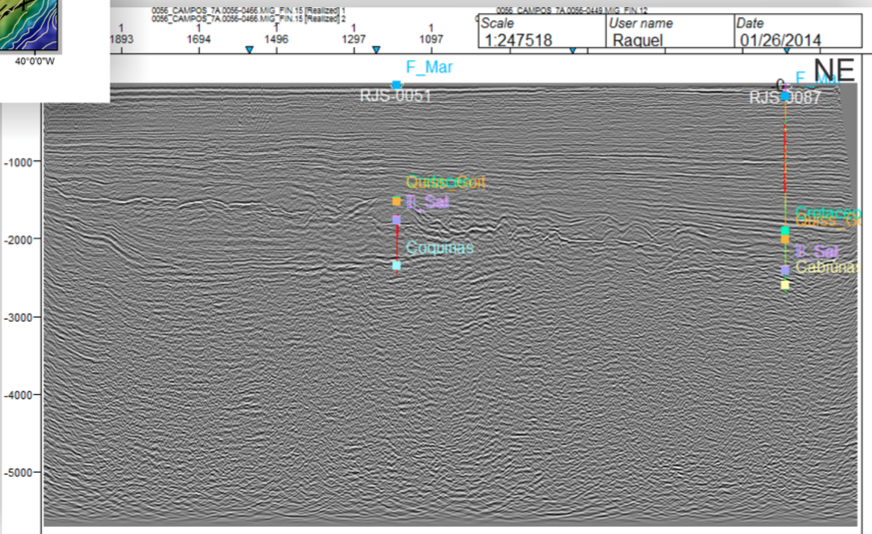

In [105]:
Image("imagens/seismic.png")

Observe that the time-depth table created by the model with 16 layers is coherent with the seismic line. The end of the well is between -2000 and -3000 milliseconds. P.S.: The markers shown at the image were tied inside of the software Petrel during my master's dissertation. In that program it's possible to edit the time-depth table by visual calibration and I have used it in practically all wells. With this method it seems that visual adjustments will not be necessary of if so, the adjustment will be local and small compared to the total depth of the well.